In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
import pickle

In [ ]:
df = pd.read_csv("transaction_dataset.csv", index_col=0)
print(df.shape)
df.head()

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
# Ommit first two columns (Index, Adress)
df = df.iloc[:,2:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

In [ ]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,NaN,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [ ]:
for i in df[categories].columns:
  print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

The categorical column -- ERC20 most sent token type-- has --304-- unique values
The categorical column -- ERC20_most_rec_token_type-- has --466-- unique values


In [ ]:
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [ ]:
df[numericals].var()

,0
FLAG,1.724110e-01
Avg min between sent tnx,4.616718e+08
Avg min between received tnx,5.327656e+08
Time Diff between first and last (Mins),1.042889e+11
Sent tnx,5.733918e+05
Received Tnx,8.851734e+05
Number of Created Contracts,2.000685e+04
Unique Received From Addresses,8.917457e+04
Unique Sent To Addresses,6.960121e+04
min value received,1.062298e+05


FLAG
0    7662
1    2179
Name: count, dtype: int64


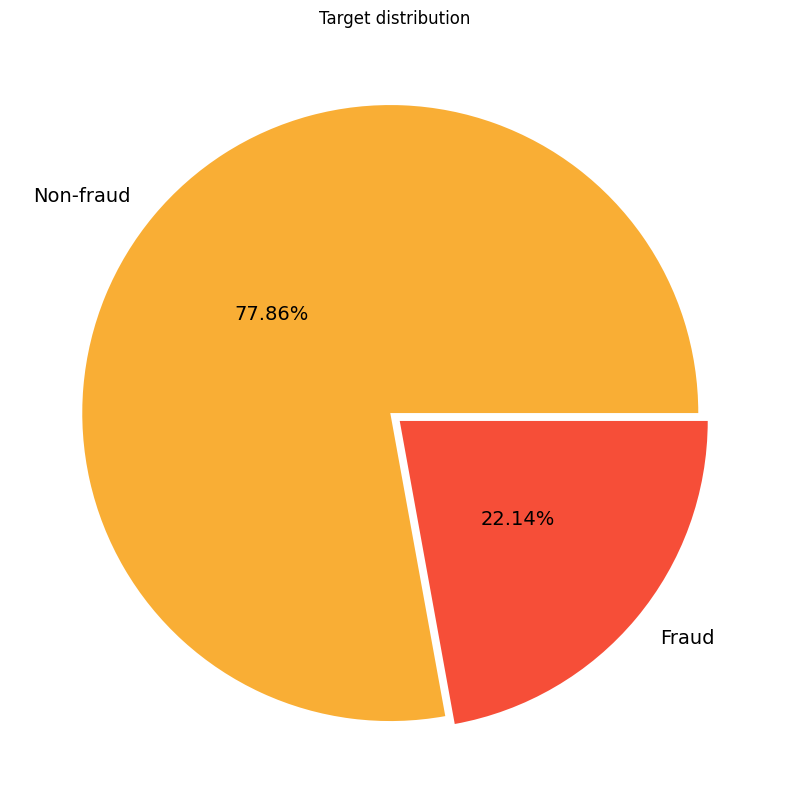

In [ ]:
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

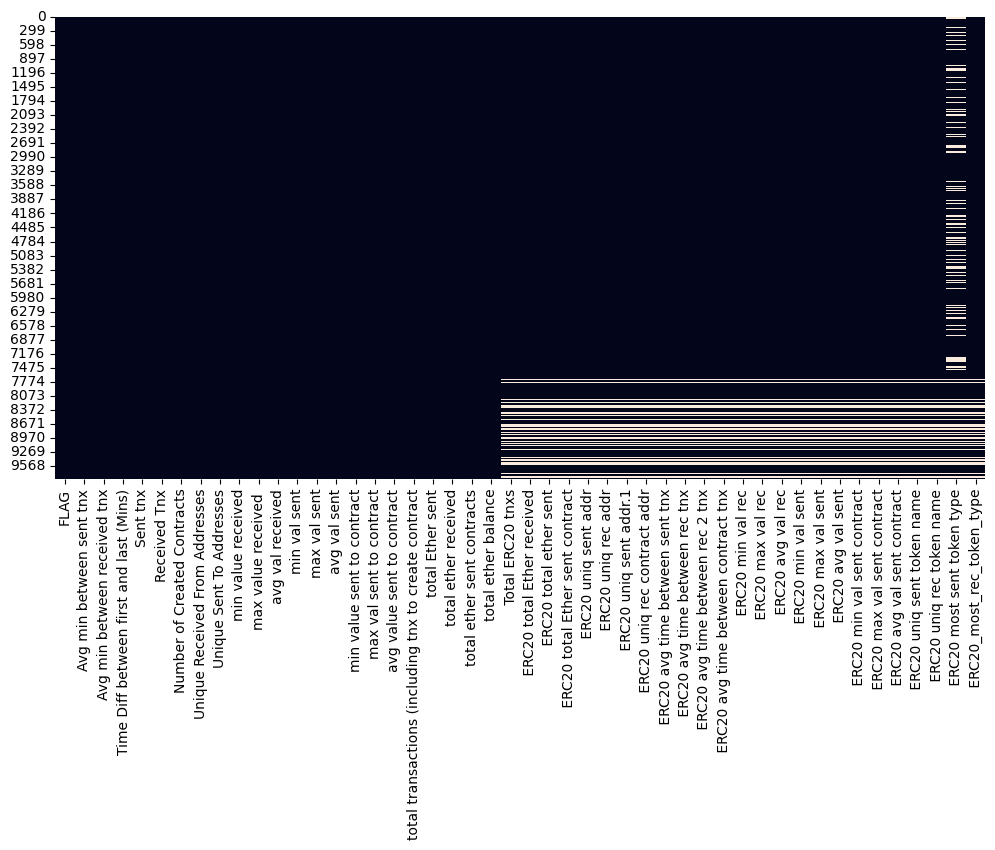

In [ ]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)

In [ ]:
df.fillna(df.median(), inplace=True)

In [ ]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

ERC20 avg time between sent tnx        0.0
ERC20 avg time between rec tnx         0.0
ERC20 avg time between rec 2 tnx       0.0
ERC20 avg time between contract tnx    0.0
ERC20 min val sent contract            0.0
ERC20 max val sent contract            0.0
ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 39 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

In [ ]:
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)


In [ ]:
columns = df.columns
columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'min value sent to contract',
       'total Ether sent', 'total ether balance',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec token name'],
      dtype='object')

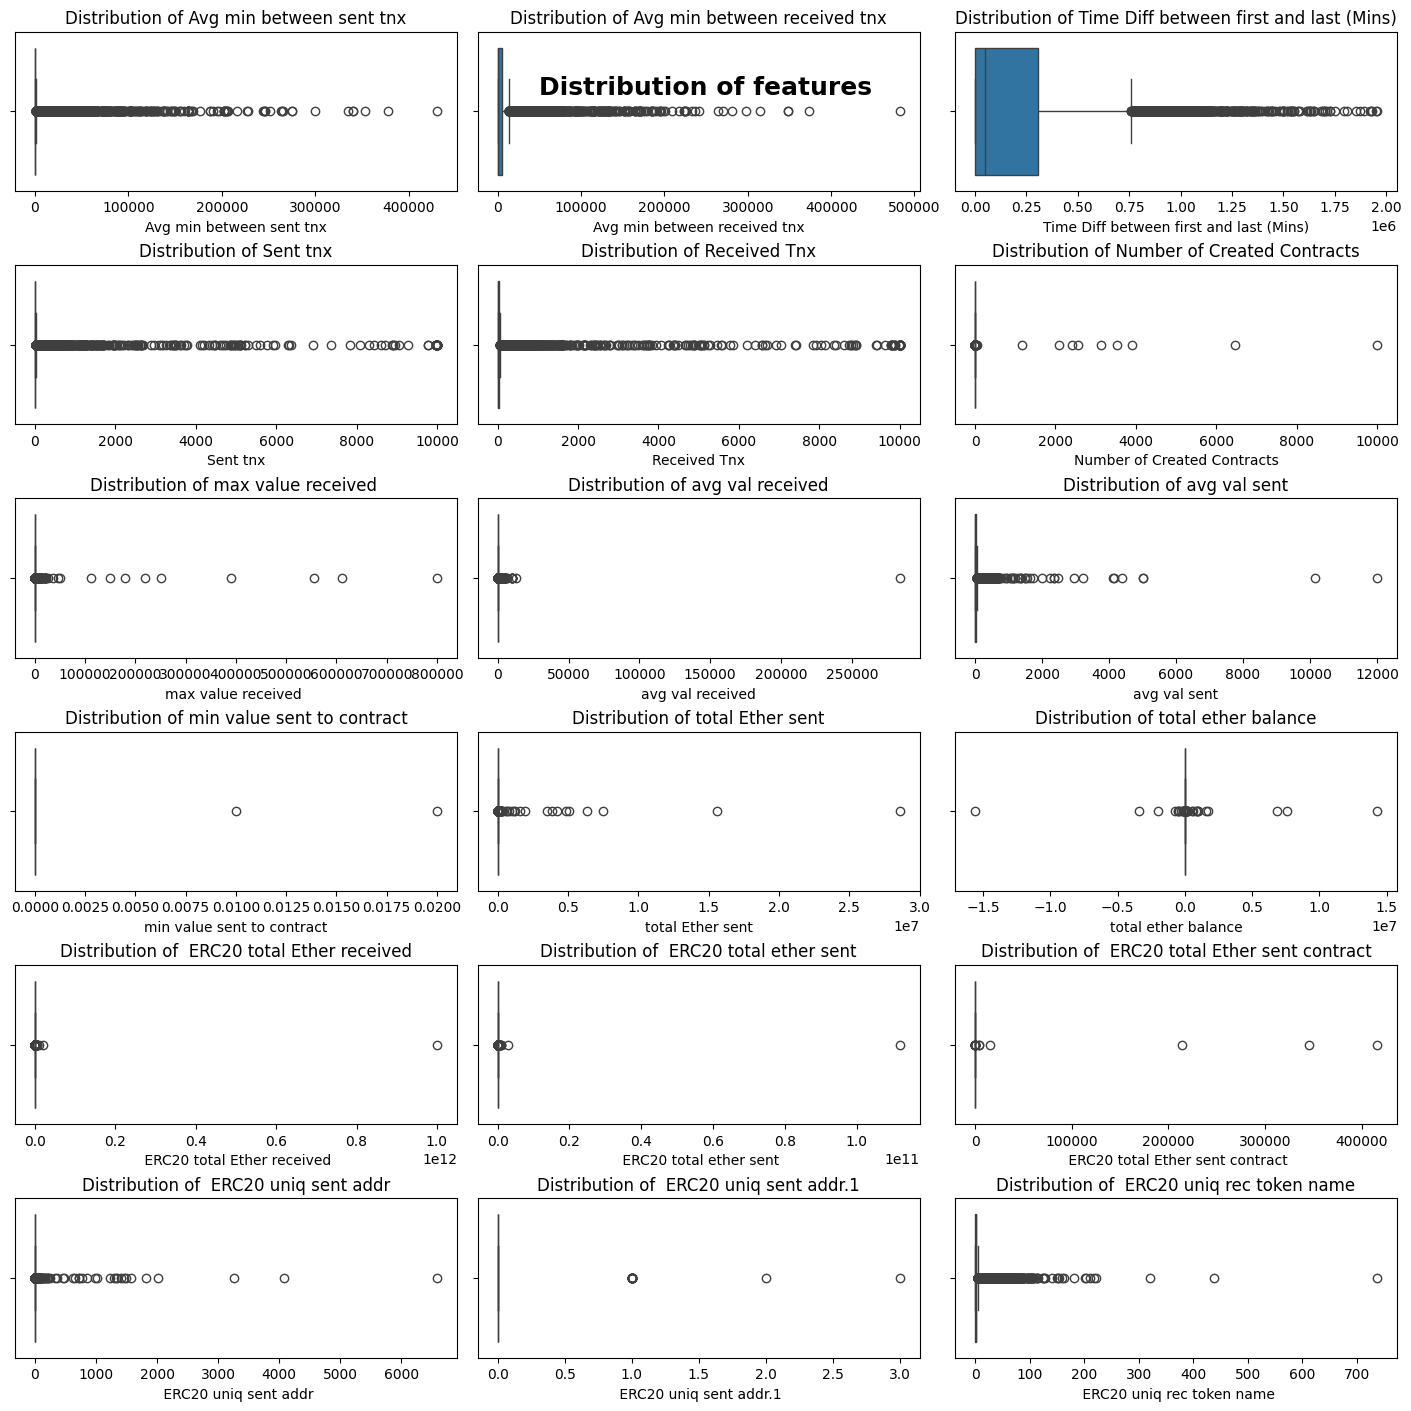

In [ ]:
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.5, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')

ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')

ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')

ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')

ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')

ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')

ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')

ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

plt.show()

In [ ]:
# Split into training (80%) and testing set (20%)
X = df.drop('FLAG', axis=1)  # Define features
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 18) (7872,)
(1969, 18) (1969,)


In [ ]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [ ]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,min value sent to contract,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq sent addr.1,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,-0.401539,1.170696,0.988757,0.651223,-0.015941,1.416308,-0.007274,1.815951,2.508169,-0.038483,2.398649,-0.057566,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-0.401539,-1.407378,-1.283886,-1.138468,-0.015941,-1.252291,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,-0.057566,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,-0.401539,0.613575,-0.995919,-0.869934,-0.015941,1.171479,-0.006819,-0.746114,-0.410600,-0.038483,-0.437145,-0.057566,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,2.490307,-0.871196,-0.822389,-1.138468,-0.015941,-1.252291,-0.006832,-0.746114,-0.410600,-0.038483,-0.437145,-0.057566,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.401539,0.889875,1.277099,1.332663,-0.015941,0.787323,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,-0.057566,-0.994019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7867,-1.096066,0.249518,-0.705997,-0.590325,-0.618856,-0.401539,-0.535113,-0.269750,0.183532,-0.015941,-0.463079,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,-0.057566,0.226082
7868,1.128623,0.633621,0.895636,0.707356,1.432439,-0.401539,0.339924,-0.354586,1.043745,-0.015941,1.010645,-0.006835,1.611838,-0.410600,-0.038483,-0.437145,-0.057566,1.238838
7869,-1.096066,-1.184221,-1.154101,-0.590325,-1.004903,-0.401539,-1.275895,-1.091970,-0.960939,-0.015941,-1.159157,-0.006835,-0.746114,-0.410600,-0.038483,-0.437145,-0.057566,-0.994019
7870,1.385084,0.988959,0.715180,0.707356,0.556810,-0.401539,1.858790,1.531808,1.671553,-0.015941,1.592460,-0.006835,1.514388,-0.410600,-0.038483,-0.437145,-0.057566,1.122262


In [ ]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 18), (7872,))
Shape of the training after SMOTE: ((12230, 18), (12230,))


In [ ]:
non_fraud = 0
fraud = 0

for i in y_train:
  if i == 0:
    non_fraud +=1
  else:
    fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
  if j == 0:
    no +=1
  else:
    yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757
AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


In [ ]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

In [ ]:
print(y_test.shape)
y_test.value_counts()

(1969,)


,count
FLAG,
0,1547
1,422


In [ ]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
# plot_confusion_matrix(RF, norm_test_f, y_test)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1547
           1       0.94      0.96      0.95       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1521   26]
 [  18  404]]


In [ ]:
xgb_c = xgb.XGBClassifier(seed=42)
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(norm_test_f)

print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))
# plot_confusion_matrix(xgb_c, norm_test_f, y_test)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1547
           1       0.94      0.95      0.94       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.96      1969
weighted avg       0.98      0.98      0.98      1969

[[1520   27]
 [  22  400]]
